Objectif : prédire les émissions de CO₂ (WLTP) d’un véhicule à partir de ses caractéristiques techniques  via une régression supervisée

In [1]:
import pandas as pd 
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, Ridge, ElasticNetCV
from sklearn.model_selection import cross_validate, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import learning_curve
from scipy.stats import randint


import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df = pd.read_csv(r"C:\Users\alexd\Desktop\WorkSpace\NoteBook_Jupyter\Projet_DA_DST_Co2\Data_Clean\Co2_sample_v3.csv")

In [ ]:
data = df[["Constructeur","WLTP_poids","Co2_Emission(WLTP)","Type_Carburant","Puissance_KW","Fuel consumption","Pays"]]

data = data[data["Type_Carburant"] != "Electric"]

In [32]:
target = data["Co2_Emission(WLTP)"]
data = data.drop(columns="Co2_Emission(WLTP)")

In [33]:
target_sans_fuel = data_sans_fuel["Co2_Emission(WLTP)"]
data_sans_fuel = data_sans_fuel.drop(columns="Co2_Emission(WLTP)")

                  WLTP_poids  Puissance_KW  Fuel consumption
WLTP_poids          1.000000      0.786405         -0.125935
Puissance_KW        0.786405      1.000000          0.074386
Fuel consumption   -0.125935      0.074386          1.000000


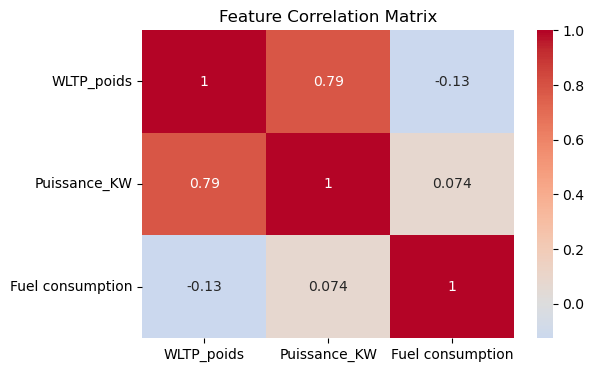

In [34]:
corr_matrix = data.corr(numeric_only=True)
print(corr_matrix)
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()

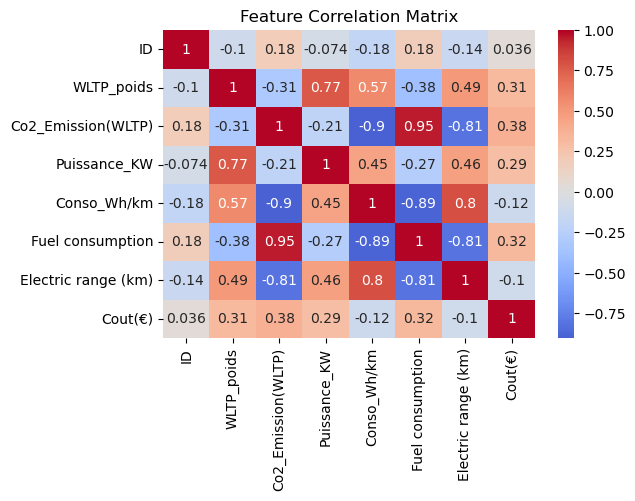

In [79]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()

C:\Users\alexd\AppData\Local\Temp\ipykernel_18428\1223172077.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\alexd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


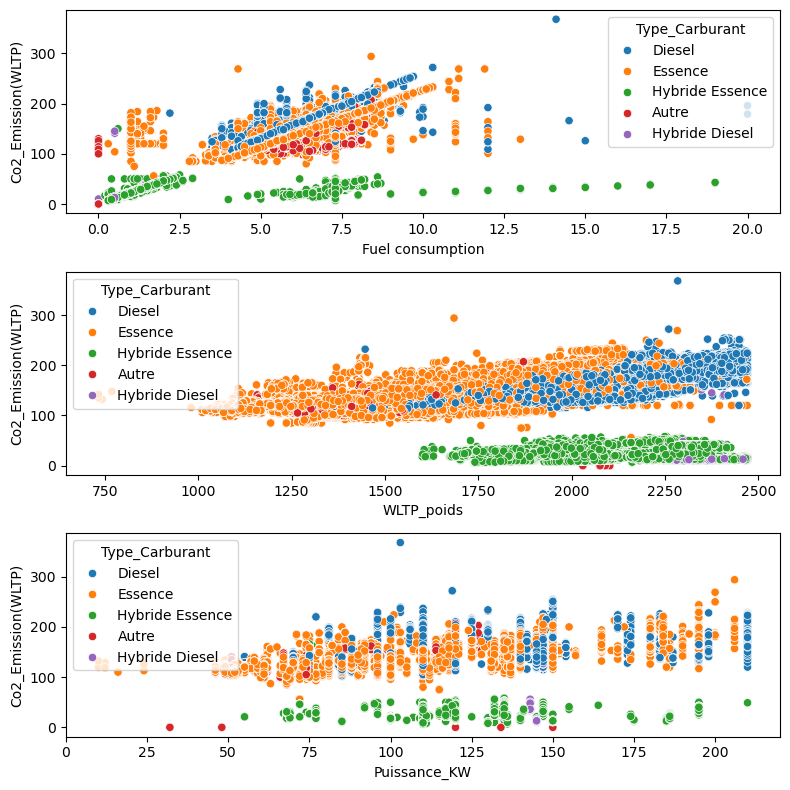

In [25]:
scatter = df[["Constructeur","WLTP_poids","Co2_Emission(WLTP)","Type_Carburant","Puissance_KW","Fuel consumption","Pays"]]

scatter = scatter[scatter["Type_Carburant"] != "Electric"]

plt.figure(figsize=(8,8))

plt.subplot(311)
sns.scatterplot(data = scatter, x = "Fuel consumption", y = "Co2_Emission(WLTP)", hue = "Type_Carburant")

plt.subplot(312)
sns.scatterplot(data = scatter, x = "WLTP_poids", y = "Co2_Emission(WLTP)", hue = "Type_Carburant")

plt.subplot(313)
sns.scatterplot(data = scatter, x = "Puissance_KW", y = "Co2_Emission(WLTP)", hue = "Type_Carburant")

plt.tight_layout()
plt.show()

In [ ]:
%%time

num_features = make_column_selector(dtype_exclude=["category","object"])(data)
cat_features = make_column_selector(dtype_include=["category","object"])(data)

kf = KFold(n_splits = 10, shuffle=True, random_state=42)

num_prepocessor = Pipeline(
    steps = [
        ("impute",SimpleImputer(strategy="median")),
         ("scaler", StandardScaler())
    ]
)

cat_prepocessor = Pipeline(
    steps = [
         ("impute", SimpleImputer(strategy="constant", fill_value="Unknown")),
         ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessors = ColumnTransformer(
    transformers = [
        ('num',num_prepocessor, num_features),
        ('cat',cat_prepocessor, cat_features)
        
    ]
)



CPU times: total: 15.6 ms
Wall time: 15.8 ms


In [96]:
%%time

model_LR = Pipeline(
    steps = [
        ("preprocessors", preprocessors),
        ("linreg", LinearRegression())
    ]
)

r2_scores = cross_validate(model_LR, data, target, cv = kf, scoring = "r2", return_train_score=True)
test_mean_r2 = r2_scores["test_score"].mean()
train_mean_r2 = r2_scores["train_score"].mean()

mse_scores = cross_validate(model_LR, data, target, cv = kf, scoring = "neg_mean_squared_error", return_train_score=True)
test_mean_mse = -mse_scores["test_score"].mean()
train_mean_mse = -mse_scores["train_score"].mean()


results = []

results.append({
    "model" : "LinearRegression",
    "R² - Test_score" : np.round(test_mean_r2,3),
    "R² - Train_score" : np.round(train_mean_r2,3),
    "MSE - Test_score" : np.round(test_mean_mse,3),
    "MSE - Train_score" : np.round(train_mean_mse,3)
    
})



CPU times: total: 16min 11s
Wall time: 2min 59s


In [99]:
model_LR

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['WLTP_poids', 'Puissance_KW',
                                                   'Fuel consumption']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Constructeur',
                                                   'Type_Carburant',
                                                   'Pays'])])),
                ('linreg', LinearRegression())])

In [ ]:
# %%time

# model_ridge = Pipeline([
#     ("preprocessors", preprocessors),
#     ("reg", Ridge())
# ])

# param_grid = {
#     "reg__alpha": [0.01, 0.1, 1, 10, 100]
# }

# gs_ridge = GridSearchCV(
#     model_ridge,
#     param_grid=param_grid,
#     cv=5,
#     scoring="r2",
#     n_jobs=-1,
#     return_train_score = True
# )

# gs_ridge.fit(data, target)


# best_ridge = gs_ridge.best_estimator_

# coefs = best_ridge.named_steps["reg"].coef_
# importance = np.abs(coefs)

# cv_res = pd.DataFrame(gs_ridge.cv_results_)

# best_idx = gs_ridge.best_index_

# mean_test_score = cv_res.loc[best_idx, "mean_test_score"]
# mean_train_score = cv_res.loc[best_idx, "mean_train_score"]


# results.append({
#     "model": "Ridge",
#     "R² - Test_score" : np.round(mean_test_score,3),
#     "R² - Train_score" : np.round(mean_train_score,3),
#     "best_alpha": gs_ridge.best_params_["reg__alpha"]
# })


CPU times: total: 25.3 s
Wall time: 46.1 s


In [98]:
df_results = pd.DataFrame(results)
df_results.sort_values("R² - Test_score", ascending=False)
display(df_results.T)


,0
model,LinearRegression
R² - Test_score,0.928
R² - Train_score,0.928
MSE - Test_score,74.186
MSE - Train_score,74.143


In [91]:
y_shuffled = np.random.permutation(target)

r2_shuff = cross_val_score(model_LR, data, y_shuffled, cv=kf, scoring="r2", n_jobs=-1).mean()
print("R2 avec y mélangé :", r2_shuff)

R2 avec y mélangé : -0.00014143471301305554


In [11]:

# def adjusted_r2_cv(model, X, y, cv=kf):
#     cv_results = cross_validate(model, data, target, cv=kf, scoring="r2")
#     r2_scores = cv_results["test_score"]
#     n = data.shape[0]
#     p = data.shape[1]
#     adj_r2 = 1 - (1 - r2_scores) * (n - 1) / (n - p - 1)
#     return adj_r2.mean()

# adj_r2 = adjusted_r2_cv(model, data, target, cv=kf)
# print("Adjusted R² (CV):", adj_r2)



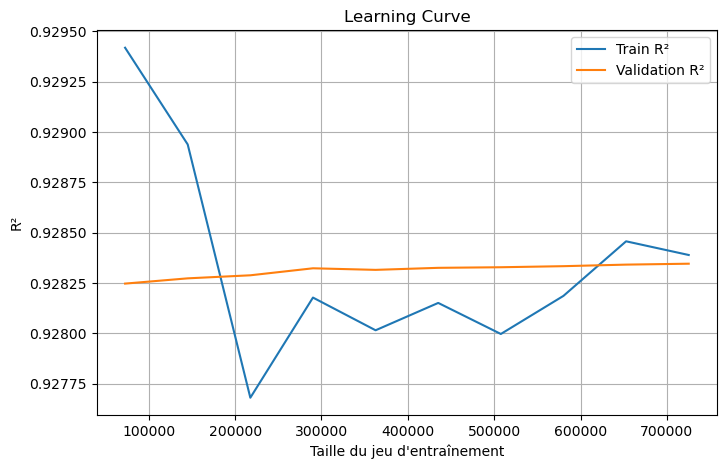

In [80]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_LR,
    X=data,
    y=target,
    cv=kf,
    scoring="r2",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)


train_mean = train_scores.mean(axis=1)
#train_std = train_scores.std(axis=1)

test_mean = test_scores.mean(axis=1)
#test_std = test_scores.std(axis=1)


plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label="Train R²")
plt.plot(train_sizes, test_mean, label="Validation R²")

#plt.fill_between(train_sizes,
                 #train_mean - train_std,
                 #train_mean + train_std,
                 #alpha=0.2)

#plt.fill_between(train_sizes,
                 #test_mean - test_std,
                 #test_mean + test_std,
                 #alpha=0.2)

plt.xlabel("Taille du jeu d'entraînement")
plt.ylabel("R²")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

In [100]:
model_clean = model_LR.fit(data,target)

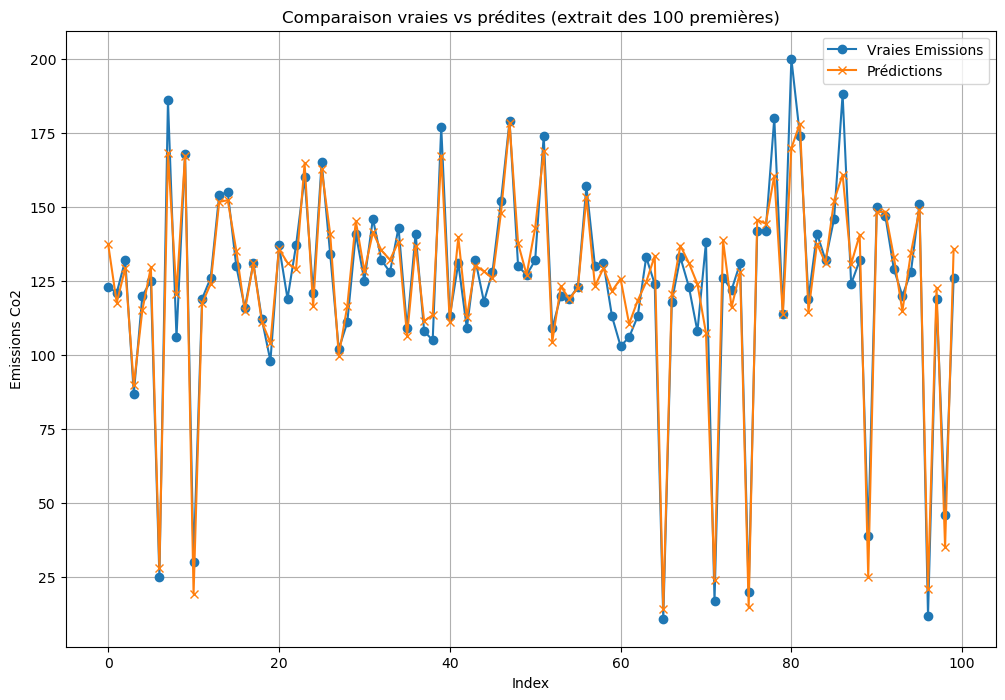

In [125]:
train_preds = model_clean.predict(data)

plt.figure(figsize=(12,8))
plt.plot(target.values[:100], label="Vraies Emissions", marker='o')
plt.plot(train_preds[:100], label="Prédictions", marker='x')
plt.legend()
plt.title("Comparaison vraies vs prédites (extrait des 100 premières)")
plt.xlabel("Index")
plt.ylabel("Emissions Co2")
plt.grid(True)
plt.legend(loc = "upper right")
plt.show()

In [117]:
prediction = train_preds - target
prediction = pd.DataFrame(prediction)
prediction["Prédictions"] = train_preds
prediction["Valeurs Réelles"] = target

prediction = prediction.rename(columns = ({"Co2_Emission(WLTP)" : "delta"}))

prediction

,delta,Prédictions,Valeurs Réelles
0,14.406648,137.406648,123.0
1,-3.355552,117.644448,121.0
2,-2.661406,129.338594,132.0
3,2.754356,89.754356,87.0
4,-4.881058,115.118942,120.0
...,...,...,...
899995,0.373794,110.373794,110.0
899996,-0.531867,125.468133,126.0
899997,-3.324033,126.675967,130.0
899998,12.827045,152.827045,140.0


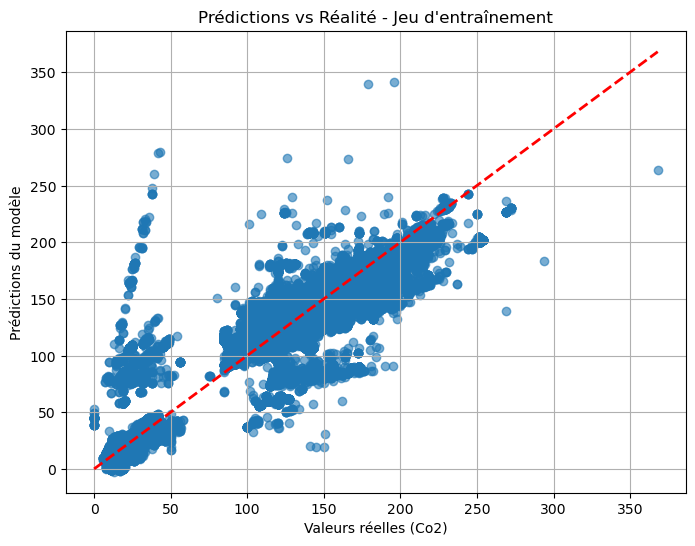

In [44]:
plt.figure(figsize=(8,6))
plt.scatter(target, train_preds, alpha=0.6)
plt.plot([target.min(), target.max()], [target.min(), target.max()], 'r--', lw=2)  
plt.xlabel("Valeurs réelles (Co2)")
plt.ylabel("Prédictions du modèle")
plt.title("Prédictions vs Réalité - Jeu d'entraînement")
plt.grid(True)
plt.show()

Conclusion : 

Cette approche de régression supervisée montre qu’il est possible de prédire efficacement les émissions de CO₂ des véhicules thermiques à partir de leurs caractéristiques techniques. La combinaison d’un prétraitement robuste, d’une validation croisée et d’un modèle interprétable permet d’obtenir des performances élevées sans surapprentissage.


In [65]:
feature_names = best_ridge.named_steps["preprocessors"].get_feature_names_out()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "importance": np.abs(coefs)
}).sort_values("importance", ascending=False)

coef_df.head(20)

,feature,coef,importance
66,cat__Type_Carburant_Hybride Diesel,-36.416989,36.416989
64,cat__Type_Carburant_Diesel,34.799751,34.799751
67,cat__Type_Carburant_Hybride Essence,-34.004989,34.004989
65,cat__Type_Carburant_Essence,25.215673,25.215673
90,cat__Pays_Romania,-21.761019,21.761019
77,cat__Pays_Greece,20.937979,20.937979
49,cat__Constructeur_PORSCHE,20.824892,20.824892
56,cat__Constructeur_SSANGYONG,18.886816,18.886816
2,num__Fuel consumption,17.886688,17.886688
55,cat__Constructeur_SPORTEQUIPE,13.798023,13.798023
